In [1]:
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [2]:
def gradcam(model, img_path, classes_name, con_layer_name, alpha):
    input_img = image.load_img(img_path, target_size=K.int_shape(model.input)[1:3])
    input_img = np.array(input_img)
    input_img = np.expand_dims(input_img,0)    
    # Get image class predicted value by model
    preds = model.predict(input_img)
    pred_class = np.argmax(preds[0])
    # Get image class predicted name by model
    pred_class_name = classes_name[pred_class]
    # Get predict class output vector
    pred_output = model.output[:, pred_class]
    # Get the last convolution layer by the layer name
    last_conv_layer = model.get_layer(con_layer_name)
    # Get gradient by the last convolution layer of the prediction class
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    # Sum all the gradient along the number of feature maps
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    # Combine into a function and throw an image as input
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([input_img])
    # Multply each feature maps with weights(gradient)
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
    # Sum feature map channel-wise
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    # Standardization
    heatmap /= np.max(heatmap)
    img = np.array(image.load_img(img_path, target_size=K.int_shape(model.input)[1:3]))
    fig, ax = plt.subplots()
    im = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_jet = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_jet[np.where(heatmap < 0.2)] = 0
    # Combine heatmap and original image with alpha value
    superimposed_img = heatmap_jet*alpha + im*(1-alpha)
    superimposed_img = cv2.cvtColor(superimposed_img.astype("uint8"), cv2.COLOR_BGR2RGB)
    ax.imshow(superimposed_img)
    plt.title(pred_class_name+" "+str(round(np.max(preds[0]),3)))
    plt.show()

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet')
# model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
with open('imagenet_class_index.json' , 'r') as reader:
    jf = json.loads(reader.read())
classes_name = [i[1] for i in list(jf.values())]

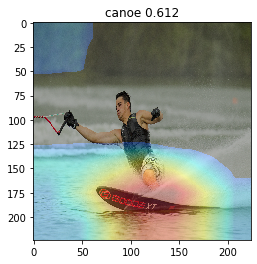

In [5]:
img_path_list = glob.glob('example_imgs/*.*')
img_path = np.random.choice(img_path_list,1)[0]
'''
res5c_branch2c is the name of the last convolutional layer in ResNet50
'''
gradcam(model, img_path, classes_name, con_layer_name = 'res5c_branch2c', alpha = 0.3)